In [54]:
%conda update -n base conda
%conda install pytorch
%conda install torchvision
%pip install torch-summary
%pip install matplotlib

Solving environment: done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - conda


The following NEW packages will be INSTALLED:

  bzip2              conda-forge/linux-64::bzip2-1.0.8-h7f98852_4
  libnsl             conda-forge/linux-64::libnsl-2.0.0-h7f98852_0
  libsqlite          conda-forge/linux-64::libsqlite-3.39.4-h753d276_0
  libuuid            conda-forge/linux-64::libuuid-2.32.1-h7f98852_1000
  libzlib            conda-forge/linux-64::libzlib-1.2.13-h166bdaf_4
  toolz              conda-forge/noarch::toolz-0.12.0-pyhd8ed1ab_0

The following packages will be REMOVED:

  chardet-4.0.0-py39hf3d152e_1
  libstdcxx-ng-11.2.0-he4da1e4_9
  six-1.16.0-pyh6c4a22f_0
  zlib-1.2.11-h516909a_1010

The following packages will be UPDATED:

  _openmp_mutex                                   4.5-1_gnu --> 4.5-2_gnu
  brotlipy                          0.7.0-py39h3811e60_1001 --> 0.7.0-py39hb9d737c_1005
  ca-certificates                      2021.5.30-ha8785

In [55]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import torchsummary
import matplotlib.pyplot as plt
import os
import sys
import time
import math

In [56]:
def get_mean_and_std(dataset):
    '''Compute the mean and std value of dataset.'''
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True, num_workers=2)
    mean = torch.zeros(3)
    std = torch.zeros(3)
    print('==> Computing mean and std..')
    for inputs, targets in dataloader:
        for i in range(3):
            mean[i] += inputs[:,i,:,:].mean()
            std[i] += inputs[:,i,:,:].std()
    mean.div_(len(dataset))
    std.div_(len(dataset))
    return mean, std


def init_params(net):
    '''Init layer parameters.'''
    for m in net.modules():
        if isinstance(m, nn.Conv2d):
            init.kaiming_normal(m.weight, mode='fan_out')
            if m.bias:
                init.constant(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d):
            init.constant(m.weight, 1)
            init.constant(m.bias, 0)
        elif isinstance(m, nn.Linear):
            init.normal(m.weight, std=1e-3)
            if m.bias:
                init.constant(m.bias, 0)


# _, term_width = os.popen('stty size', 'r').read().split()
term_width = 50

TOTAL_BAR_LENGTH = 65.
last_time = time.time()
begin_time = last_time


def progress_bar(current, total, msg=None):
    global last_time, begin_time
    if current == 0:
        begin_time = time.time()  # Reset for new bar.

    cur_len = int(TOTAL_BAR_LENGTH*current/total)
    rest_len = int(TOTAL_BAR_LENGTH - cur_len) - 1

    sys.stdout.write(' [')
    for i in range(cur_len):
        sys.stdout.write('=')
    sys.stdout.write('>')
    for i in range(rest_len):
        sys.stdout.write('.')
    sys.stdout.write(']')

    cur_time = time.time()
    step_time = cur_time - last_time
    last_time = cur_time
    tot_time = cur_time - begin_time

    L = []
    L.append('  Step: %s' % format_time(step_time))
    L.append(' | Tot: %s' % format_time(tot_time))
    if msg:
        L.append(' | ' + msg)

    msg = ''.join(L)
    sys.stdout.write(msg)
    for i in range(term_width-int(TOTAL_BAR_LENGTH)-len(msg)-3):
        sys.stdout.write(' ')

    # Go back to the center of the bar.
    for i in range(term_width-int(TOTAL_BAR_LENGTH/2)+2):
        sys.stdout.write('\b')
    sys.stdout.write(' %d/%d ' % (current+1, total))

    if current < total-1:
        sys.stdout.write('\r')
    else:
        sys.stdout.write('\n')
    sys.stdout.flush()


def format_time(seconds):
    days = int(seconds / 3600/24)
    seconds = seconds - days*3600*24
    hours = int(seconds / 3600)
    seconds = seconds - hours*3600
    minutes = int(seconds / 60)
    seconds = seconds - minutes*60
    secondsf = int(seconds)
    seconds = seconds - secondsf
    millis = int(seconds*1000)

    f = ''
    i = 1
    if days > 0:
        f += str(days) + 'D'
        i += 1
    if hours > 0 and i <= 2:
        f += str(hours) + 'h'
        i += 1
    if minutes > 0 and i <= 2:
        f += str(minutes) + 'm'
        i += 1
    if secondsf > 0 and i <= 2:
        f += str(secondsf) + 's'
        i += 1
    if millis > 0 and i <= 2:
        f += str(millis) + 'ms'
        i += 1
    if f == '':
        f = '0ms'
    return f

In [57]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [58]:
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [59]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 32

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.layer1 = self._make_layer(block, 32, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 64, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 128, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 256, num_blocks[3], stride=2)
        self.dropout = nn.Dropout(p=0.2)
        self.linear = nn.Linear(256*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.dropout(out)
        out = self.linear(out)
        return out

In [60]:
def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])


def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])


def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])


def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])

In [61]:
# parser = argparse.ArgumentParser(description='PyTorch CIFAR10 Training')
# parser.add_argument('--lr', default=0.1, type=float, help='learning rate')
# parser.add_argument('--resume', '-r', action='store_true',
#                     help='resume from checkpoint')
# args = parser.parse_args()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch
Learning_rate = 0.0001
Resume = False
Optimizer = 'sgd'  # sgd, sgdn, adagrad, adadelta or adam
Batch_size = 256


# Data
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=Batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

# Model
print('==> Building model..')
net = ResNet18()
net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

if Resume:
    # Load checkpoint.
    print('==> Resuming from checkpoint..')
    assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
    checkpoint = torch.load('./checkpoint/ckpt.pth')
    net.load_state_dict(checkpoint['net'])
    best_acc = checkpoint['acc']
    start_epoch = checkpoint['epoch']

criterion = nn.CrossEntropyLoss(reduction='sum')
optimizer = optim.SGD(net.parameters(), lr=Learning_rate,
                      momentum=0.9, weight_decay=5e-4)
if Optimizer == 'sgdn':
    optimizer = optim.SGD(net.parameters(), lr=Learning_rate,
                    momentum=0.9, weight_decay=5e-4, nesterov=True)
elif Optimizer == 'adagrad':
    optimizer = optim.Adagrad(net.parameters(), lr=Learning_rate,
                              weight_decay=5e-4)
elif Optimizer == 'adadelta':
    optimizer = optim.Adadelta(net.parameters(), lr=Learning_rate,
                               weight_decay=5e-4)
elif Optimizer == 'adam':
    optimizer = optim.Adam(net.parameters(), lr=Learning_rate,
                           weight_decay=5e-4)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)

torchsummary.summary(net, (3, 32, 32))


# Training
def train(epoch):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    total_training_time = 0
    time1 = torch.cuda.Event(enable_timing=True)
    time2 = torch.cuda.Event(enable_timing=True)
    time1.record()
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        time2.record()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
        torch.cuda.synchronize()
        
        total_training_time += time1.elapsed_time(time2)
        
    avg_loss = train_loss/total
    acc = 100.*correct/total
    print('Training epoch %d: Loss=%.3f Acc=%.3f' %
          (epoch, avg_loss, acc))
    return avg_loss, acc


def test(epoch):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
        
    avg_loss = test_loss/total
    acc = 100.*correct/total
    print('Testing epoch %d: Loss=%.3f Acc=%.3f' %
          (epoch, avg_loss, acc))

    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt.pth')
        best_acc = acc
        
    return avg_loss, acc


filename = Optimizer + '_' + str(Batch_size) + '_' + str(Learning_rate) + '_dropout.csv'
file = open(filename, 'w')
file.write('train_avg_loss, train_acc, test_avg_loss, test_acc, train_time, test_time\n')
Start_time = time.perf_counter()
train_acc_history = []
test_acc_history = []
for epoch in range(start_epoch, start_epoch+80):
    time1 = time.perf_counter()
    train_avg_loss, train_acc = train(epoch)
    time2 = time.perf_counter()
    test_avg_loss, test_acc = test(epoch)
    Cur_time = time.perf_counter()
    # scheduler.step()
    train_acc_history.append(train_acc)
    test_acc_history.append(test_acc)
    print('Epoch %d: %.2fs' % (epoch, Cur_time - Start_time))
    print('Train: %.2fs, Test: %.2fs' % (time2 - time1, Cur_time - time2))
    file.write('%.3f, %.3f, %.3f, %.3f, %.2f, %.2f\n' %
               (train_avg_loss, train_acc, test_avg_loss, test_acc,
                time2 - time1, Cur_time - time2))
file.close()

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified
==> Building model..
Layer (type:depth-idx)                   Output Shape              Param #
├─ResNet: 1-1                            [-1, 10]                  --
|    └─Conv2d: 2-1                       [-1, 32, 32, 32]          864
|    └─BatchNorm2d: 2-2                  [-1, 32, 32, 32]          64
|    └─Sequential: 2-3                   [-1, 32, 32, 32]          --
|    |    └─BasicBlock: 3-1              [-1, 32, 32, 32]          18,560
|    |    └─BasicBlock: 3-2              [-1, 32, 32, 32]          18,560
|    └─Sequential: 2-4                   [-1, 64, 16, 16]          --
|    |    └─BasicBlock: 3-3              [-1, 64, 16, 16]          57,728
|    |    └─BasicBlock: 3-4              [-1, 64, 16, 16]          73,984
|    └─Sequential: 2-5                   [-1, 128, 8, 8]           --
|    |    └─BasicBlock: 3-5              [-1, 128, 8, 8]           230,144
|    |    └─Bas

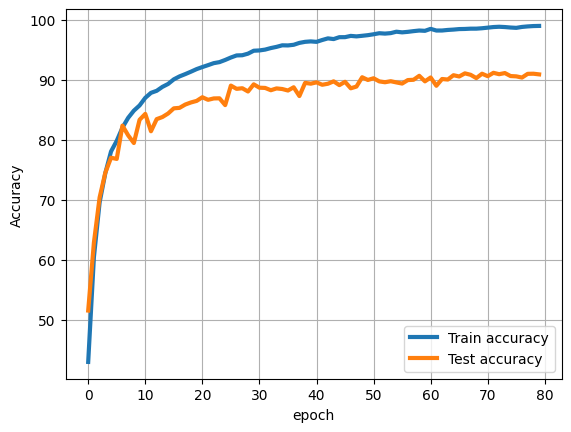

In [62]:
plt.plot(range(80),train_acc_history,'-',linewidth=3,label='Train accuracy')
plt.plot(range(80),test_acc_history,'-',linewidth=3,label='Test accuracy')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()